#Preprocessing

## Install tensorflow 2.0.0-alpha0

In [1]:
!pip install -q tensorflow-gpu==2.0.0-alpha0

    100% |████████████████████████████████| 332.1MB 40kB/s 
    100% |████████████████████████████████| 3.0MB 8.1MB/s 
    100% |████████████████████████████████| 419kB 11.9MB/s 
    100% |████████████████████████████████| 61kB 20.2MB/s 


##Import Module

In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
from scipy.io import loadmat, savemat
import matplotlib.pyplot as plt
import zipfile
import os
import time
import zipfile
import re
import cv2
import glob
import imageio
import matplotlib.image as mpimg
from tensorflow.keras import layers
from PIL import Image
from IPython import display
%matplotlib inline
print("tensorflow version: %s"%tf.__version__)
print(cv2.__version__)

tensorflow version: 2.0.0-alpha0
4.1.0


##Load Images

In [0]:
ymu = loadmat('Makeup_YMU.mat')
vmu = loadmat('Makeup_VMU.mat')
# miw = loadmat('Makeup_MIW.mat')

In [4]:
vmu_names = vmu['VMU_filenames']
vmu_names = vmu_names.reshape(vmu_names.shape[1])
vmu_names = np.array([i[0] for i in vmu_names])
print(vmu_names.shape)
ymu_names = ymu['YMU_filenames']
ymu_names = ymu_names.reshape(ymu_names.shape[1])
ymu_names = np.array([i[0] for i in ymu_names])
print(ymu_names.shape)

(257,)
(604,)


In [0]:
def swap_image(data):
    '''
    reshape and swap the axies of the original data to make the image visble 
    '''
    new_data = data.reshape(3, 130, 150, data.shape[1])
    new_data = np.swapaxes(new_data, 0, 2)
    new_data = np.swapaxes(new_data, 2, 3)
    new_data = np.swapaxes(new_data, 1, 2)
    new_data = np.swapaxes(new_data, 0, 1)
    return new_data

In [0]:
ymu_data = swap_image(ymu['YMU_matrix'])
vmu_data = swap_image(vmu['VMU_matrix'])
# miw_data = swap_image(miw['MIW_matrix'])

In [7]:
ymu_n = [i for i in range(ymu_names.shape[0]) if ymu_names[i].split("_")[2]=="n.jpg"]
print(len(ymu_n))
ymu_y = [i for i in range(ymu_names.shape[0]) if ymu_names[i].split("_")[2]=="y.jpg"]
print(len(ymu_y))
vmu_n = [i for i in range(vmu_names.shape[0]) if len(vmu_names[i].split("_"))==1]
print(len(vmu_n))
vmu_y = [i for i in range(vmu_names.shape[0]) if len(vmu_names[i].split("_"))==2 and vmu_names[i].split("_")[1]=="mu.jpg"]
print(len(vmu_y))
vmu_e = [i for i in range(vmu_names.shape[0]) if len(vmu_names[i].split("_"))==2 and vmu_names[i].split("_")[1]=="e.jpg"]
print(len(vmu_e))
vmu_l = [i for i in range(vmu_names.shape[0]) if len(vmu_names[i].split("_"))==2 and vmu_names[i].split("_")[1]=="l.jpg"]
print(len(vmu_l))

302
302
104
51
51
51


In [33]:
ymu_n_data = ymu_data[ymu_n]
ymu_y_data = ymu_data[ymu_y]
vmu_n_data = ymu_data[vmu_n]
vmu_y_data = ymu_data[vmu_y]
vmu_dict = {k.split(".")[0]: v for k, v in zip(vmu_names[vmu_n], vmu_n)}
vmu_n_n = [i.split(".")[0] for i in vmu_names[vmu_n]]
vmu_e_n = [vmu_dict[i.split("_")[0]] for i in vmu_names[vmu_y] if i.split("_")[0] in vmu_n_n]
data_n = np.concatenate((ymu_data[ymu_n], vmu_data[vmu_e_n]), axis=0)
data_y = np.concatenate((ymu_data[ymu_y], vmu_data[vmu_y]), axis=0)
data_n = np.array([cv2.resize(i, dsize=(128, 128)) for i in data_n])
data_y = np.array([cv2.resize(i, dsize=(128, 128)) for i in data_y])
data_n = np.concatenate((data_n, np.flip(data_n, 2)), axis=0)
data_y = np.concatenate((data_y, np.flip(data_y, 2)), axis=0)
print(data_n.shape)
print(data_y.shape)

(706, 128, 128, 3)
(706, 128, 128, 3)


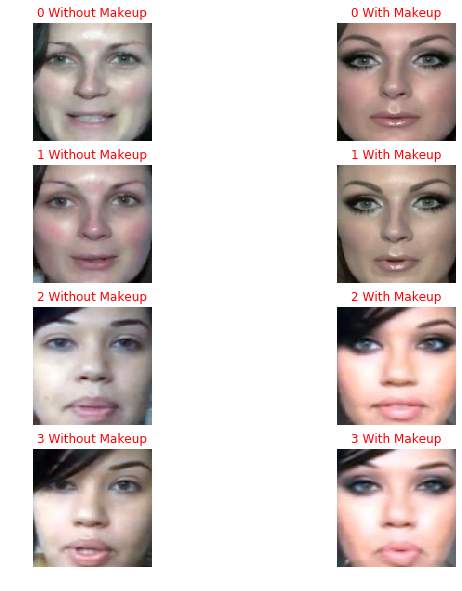

In [34]:
fig, axs = plt.subplots(4, 2, figsize=(10,10))
for i in range(4):
    axs[i,0].imshow(data_n[i])
    axs[i,1].imshow(data_y[i])
    axs[i,0].set_title("%d Without Makeup"%i, color='r')
    axs[i,1].set_title("%d With Makeup"%i, color='r')
    axs[i,0].axis("off")
    axs[i,1].axis("off")
plt.show()

In [0]:
np.save("data_y.npy", data_y)
np.save("data_n.npy", data_n)
savemat("Processed_data.mat",{"data_y":data_y, "data_n":data_n})

##Directly Load Processed Image Data

In [10]:
full_data = loadmat("Processed_data.mat")
data_y = full_data['data_y']
data_n = full_data['data_n']

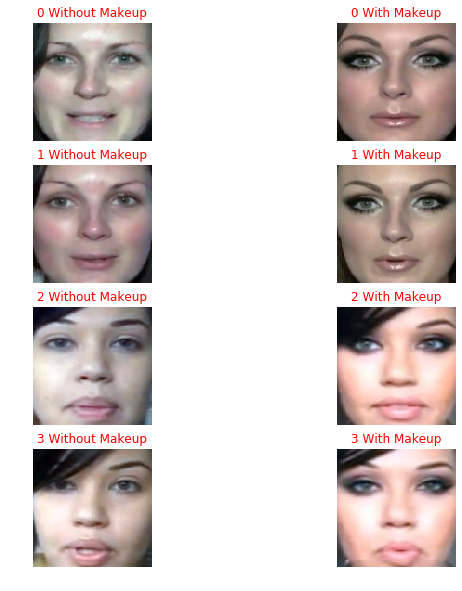

In [11]:
data_n = (data_n / 127.5) - 1.
data_y = (data_y / 127.5) - 1.
data_n = np.float32(data_n)
data_y = np.float32(data_y)
fig, axs = plt.subplots(4, 2, figsize=(10,10))
for i in range(4):
    axs[i,0].imshow(((data_n[i]+1.)*127.5).astype(int))
    axs[i,1].imshow(((data_y[i]+1.)*127.5).astype(int))
    axs[i,0].set_title("%d Without Makeup"%i, color='r')
    axs[i,1].set_title("%d With Makeup"%i, color='r')
    axs[i,0].axis("off")
    axs[i,1].axis("off")
plt.show()

#GAN

In [4]:
OUTPUT_CHANNELS = 3

In [5]:
def downsample(x, filters, size, apply_batchnorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    x = layers.Conv2D(filters,
                      kernel_size=(size, size),
                      strides=2,
                      padding='same',
                      kernel_initializer=initializer,
                      use_bias=False)(x)
    if apply_batchnorm:
        x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)
    return x

def upsample(x1, x2, filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    x1 = layers.Conv2DTranspose(filters,
                              kernel_size=(size, size),
                              strides=2,
                              padding='same',
                              kernel_initializer=initializer,
                              use_bias=False)(x1)
    x1 = layers.BatchNormalization()(x1)
    if apply_dropout:
        x1 = layers.Dropout(0.5)(x1)
    x1 = layers.LeakyReLU()(x1)
    x = layers.concatenate([x1, x2])
    return x

def upsample_single(x, filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    x = layers.Conv2DTranspose(filters,
                              kernel_size=(size, size),
                              strides=2,
                              padding='same',
                              kernel_initializer=initializer,
                              use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    if apply_dropout:
        x = layers.Dropout(0.5)(x)
    x = layers.LeakyReLU()(x)
    return x


In [6]:
def make_generator_model():
    initializer = tf.random_normal_initializer(0., 0.02)
    g_input = layers.Input(shape=(128, 128, 3))
    down1 = downsample(g_input, 64, 4)
    down2 = downsample(down1, 128, 4)
    down3 = downsample(down2, 256, 4)
    down4 = downsample(down3, 256, 4)
    down5 = downsample(down4, 256, 4)
    down6 = downsample(down5, 256, 4)
    down7 = downsample(down6, 256, 4)

    up1 = upsample(down7, down6, 256, 4, apply_dropout=True)
    up2 = upsample(up1, down5, 256, 4, apply_dropout=True)
    up3 = upsample(up2, down4, 256, 4, apply_dropout=True)
    up4 = upsample(up3, down3, 128, 4, apply_dropout=True)
    up5 = upsample(up4, down2, 64, 4, apply_dropout=True)
    up6 = upsample_single(up5, 64, 4, apply_dropout=True)
#     up6 = upsample(up5, down1, 32, 4, apply_dropout=True)

    last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 
                                                (4, 4), 
                                                strides=2, 
                                                padding='same',
                                                kernel_initializer=initializer)(up6)
    last = layers.BatchNormalization()(last)
    out = layers.Activation('tanh')(last)
    model = tf.keras.Model(inputs=g_input, outputs=out)
    return model

In [7]:
def make_discriminator_model():
    initializer = tf.random_normal_initializer(0., 0.02)
    d_input = layers.Input(shape=(128, 128, 3))
    d_target = layers.Input(shape=(128, 128, 3))
    x = layers.concatenate([d_input, d_target])
    x = downsample(x, 64, 4, apply_batchnorm=False)
    x = downsample(x, 128, 4)
    x = layers.ZeroPadding2D()(x)
    x = layers.Conv2D(256,
                      (4, 4), 
                      strides=1, 
                      kernel_initializer=initializer, 
                      use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ZeroPadding2D()(x)
    out = layers.Conv2D(1,
                      (4, 4),
                      strides=1,
                      kernel_initializer=initializer)(x)
    model = tf.keras.Model(inputs=[d_input, d_target], outputs=out)
    return model

In [8]:
generator = make_generator_model()
discriminator = make_discriminator_model()

In [9]:
generator.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 64, 64, 64)   3072        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_v2 (BatchNo (None, 64, 64, 64)   256         conv2d[0][0]                     
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 64, 64, 64)   0           batch_normalization_v2[0][0]     
______________________________________________________________________________________________

In [10]:
discriminator.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
concatenate_5 (Concatenate)     (None, 128, 128, 6)  0           input_2[0][0]                    
                                                                 input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_7 (Conv2D)               (None, 64, 64, 64)   6144        concatenate_5[0][0]        

In [11]:
LAMBDA = 1000
def discriminator_loss(disc_real_output, disc_generated_output):
    cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
    real_loss = cross_entropy(tf.ones_like(disc_real_output),
                              disc_real_output)
    generated_loss = cross_entropy(tf.zeros_like(disc_generated_output),
                                   disc_generated_output)

    total_disc_loss = real_loss + generated_loss

    return total_disc_loss

def generator_loss(disc_generated_output, gen_output, target):
    cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
    gen_loss = cross_entropy(tf.ones_like(disc_generated_output),
                             disc_generated_output) 
    # mean absolute error
#     l1_loss = tf.reduce_mean(tf.abs(target - gen_output))
    l1_loss = -tf.image.ssim(gen_output, target, 2.0)

    total_gen_loss = gen_loss + (LAMBDA * l1_loss)

    return total_gen_loss, l1_loss

In [12]:
LAMBDA = 1000

def discriminator_loss(disc_real_output, disc_generated_output):
    disc_loss = tf.reduce_mean(disc_real_output) - tf.reduce_mean(disc_generated_output)
    return disc_loss

def generator_loss(disc_generated_output, gen_output, target):
    gen_loss = -tf.reduce_mean(disc_generated_output)
    l1_loss = -tf.image.ssim(gen_output, target, 2.0)

    total_gen_loss = gen_loss + (LAMBDA * l1_loss)

    return total_gen_loss, l1_loss    

In [13]:
clip_d = [p.assign(tf.clip_by_value(p, -0.01, 0.01)) for p in discriminator.trainable_variables]

In [14]:
generator_optimizer = tf.keras.optimizers.RMSprop(5e-5)
discriminator_optimizer = tf.keras.optimizers.RMSprop(5e-5)
# generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
# discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [15]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [16]:
@tf.function
def train_step(data_y, data_n, i):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(data_y, training=True)
        
        real_output = discriminator(inputs=[data_n, data_y], training=True)
        fake_output = discriminator(inputs=[generated_images, data_y], training=True)

        gen_loss, l1_loss = generator_loss(fake_output, generated_images, data_n)
        disc_loss = discriminator_loss(real_output, fake_output)
        if(i % 5 == 0):
            gradients_of_generator = gen_tape.gradient(gen_loss,
                                                   generator.trainable_variables)

        gradients_of_discriminator = disc_tape.gradient(disc_loss,
                                                        clip_d)
    if i % 5 == 0:
        generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    return gen_loss, disc_loss, l1_loss

In [17]:
def generate_and_save_images(model, epoch, test_input, batch=None):
    # Notice `training` is set to False.
    # This is so all layers run in inference mode (batchnorm).
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(10,6))
    
    for i in range(predictions.shape[0]):
        plt.subplot(2, 4, i+1)
        plt.imshow(np.array((predictions[i]*127.5)+127.5).astype(int))
        plt.axis('off')
    if batch is not None:
        plt.suptitle('Image at Epoch {:04d} Batch {:03d}'.format(epoch, batch), fontsize=18)
        plt.savefig('image_at_epoch_{:04d}_batch_{:03d}.png'.format(epoch, batch))
    else:
        plt.suptitle('Image at Epoch {:04d} Batch End'.format(epoch), fontsize=18)
        plt.savefig('image_at_epoch_{:04d}_batch_end.png'.format(epoch))
    plt.show()
    return predictions

In [18]:
def calculate_test_L1_loss(model, test_input, real_output):
    predictions = model(test_input, training=False)
    test_L1 = tf.image.ssim(predictions, real_output, 2.0)
    return test_L1

In [19]:
np.random.seed(100)
test_data_n = data_n[np.random.randint(data_n.shape[0]-1, size=100)]
test_data_y = data_y[np.random.randint(data_y.shape[0]-1, size=100)]
test_data_y = tf.convert_to_tensor(test_data_y)
test_data_n = tf.convert_to_tensor(test_data_n)
TEST_SAMPLE = [0,100,200,300,400,500,600,700]
test_data_sample_y = data_y[TEST_SAMPLE]
test_data_sample_n = data_n[TEST_SAMPLE]

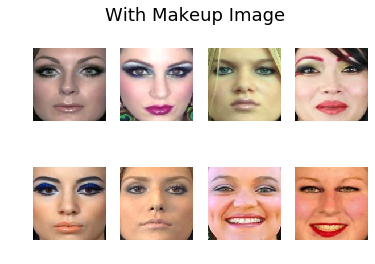

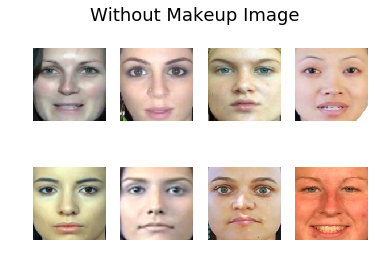

In [20]:
for i in range(test_data_sample_y.shape[0]):
    plt.subplot(2, 4, i+1)
    plt.imshow(np.array((test_data_sample_y[i]*127.5)+127.5).astype(int))
    plt.axis('off')
plt.suptitle('With Makeup Image', fontsize=18)
plt.show()
for i in range(test_data_sample_n.shape[0]):
    plt.subplot(2, 4, i+1)
    plt.imshow(np.array((test_data_sample_n[i]*127.5)+127.5).astype(int))
    plt.axis('off')
plt.suptitle('Without Makeup Image', fontsize=18)
plt.show()

In [22]:
EPOCHS = 150
BUFFER_SIZE = 720
BATCH_SIZE = 20

In [23]:
train_data = tf.data.Dataset.from_tensor_slices((data_y, data_n))
test_data = tf.data.Dataset.from_tensor_slices((test_data_y, test_data_n))
train_data = train_data.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
print(train_data)

<BatchDataset shapes: ((None, 128, 128, 3), (None, 128, 128, 3)), types: (tf.float32, tf.float32)>


In [24]:
pred, final_pred = None, None
gen_loss_list, disc_loss_list, L1_loss_list, Test_L1_loss_list = None, None, None, None

In [25]:
def train(train_dataset, test_data_sample_y, data_y, data_n, test_data_y, test_data_n, epochs):
    global pred, final_pred, gen_loss_list, disc_loss_list, l1_loss_list, Test_L1_loss_list
    for epoch in range(epochs):
        start =time.time()
        print('Epoch {} starts !'.format(epoch + 1))
        for i, (data_y, data_n) in enumerate(train_dataset):
            gen_loss, disc_loss, L1_loss = train_step(data_y, data_n, i)
            if i == 0:
                e_g_l = tf.constant([tf.reduce_mean(gen_loss).numpy()])
                e_d_l = tf.constant([tf.reduce_mean(disc_loss).numpy()])
                e_L_l = tf.constant([tf.reduce_mean(L1_loss).numpy()])
            else:
                e_g_l = tf.concat([e_g_l, [tf.reduce_mean(gen_loss)]], axis=0)
                e_d_l = tf.concat([e_d_l, [tf.reduce_mean(disc_loss)]], axis=0)
                e_L_l = tf.concat([e_L_l, [tf.reduce_mean(L1_loss)]], axis=0)
            if (i + 1) % 5 == 0:
                print('Time for epoch {} batch {} is {:.03f} sec'.format(epoch + 1,
                                                                        i + 1,
                                                                        time.time() - start))
#                 pred = generate_and_save_images(generator,
#                                      epoch + 1, test_data_sample_y, i + 1)
        train_L1_loss = calculate_test_L1_loss(generator, data_y, data_n)
        test_L1_loss = calculate_test_L1_loss(generator, test_data_y, test_data_n)
        if gen_loss_list is None:
            gen_loss_list = tf.reduce_mean(e_g_l, keepdims=True)
            disc_loss_list = tf.reduce_mean(e_d_l, keepdims=True)
            L1_loss_list = tf.reduce_mean(train_L1_loss, keepdims=True)
            Test_L1_loss_list = tf.reduce_mean(test_L1_loss, keepdims=True)
        gen_loss_list = tf.concat([gen_loss_list, [tf.reduce_mean(e_g_l)]], axis=0)
        disc_loss_list = tf.concat([disc_loss_list, [tf.reduce_mean(e_d_l)]], axis=0)
        L1_loss_list = tf.concat([L1_loss_list, [tf.reduce_mean(train_L1_loss)]], axis=0)
        Test_L1_loss_list = tf.concat([Test_L1_loss_list, [tf.reduce_mean(test_L1_loss)]], axis=0)
        if (epoch + 1) % 2 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)
            generator.save('my_gen.h5')
            discriminator.save('my_dis.h5')
        end = time.time()
        print('Time for epoch {} is {:03f} sec'.format(epoch + 1, end-start))
        print('Train L1 loss: %.3f'%tf.reduce_mean(train_L1_loss))
        print('Test L1 loss: %.3f'%tf.reduce_mean(test_L1_loss))
        if (epoch + 1) % 5 == 0:
            final_pred = generate_and_save_images(generator,
                                 epoch + 1,
                                 test_data_sample_y)
    generator.save('my_gen.h5')
    discriminator.save('my_dis.h5')            

Epoch 1 starts !
Time for epoch 1 batch 5 is 13.754 sec
Time for epoch 1 batch 10 is 23.491 sec
Time for epoch 1 batch 15 is 33.241 sec
Time for epoch 1 batch 20 is 43.231 sec
Time for epoch 1 batch 25 is 53.403 sec
Time for epoch 1 batch 30 is 63.851 sec
Time for epoch 1 batch 35 is 74.464 sec
Time for epoch 1 is 78.211639 sec
Train L1 loss: 0.042
Test L1 loss: 0.043
Epoch 2 starts !
Time for epoch 2 batch 5 is 1.407 sec
Time for epoch 2 batch 10 is 1.748 sec
Time for epoch 2 batch 15 is 2.099 sec
Time for epoch 2 batch 20 is 2.451 sec
Time for epoch 2 batch 25 is 2.788 sec
Time for epoch 2 batch 30 is 3.127 sec
Time for epoch 2 batch 35 is 3.471 sec
Time for epoch 2 is 4.681111 sec
Train L1 loss: 0.097
Test L1 loss: 0.095
Epoch 3 starts !
Time for epoch 3 batch 5 is 1.245 sec
Time for epoch 3 batch 10 is 1.586 sec
Time for epoch 3 batch 15 is 1.927 sec
Time for epoch 3 batch 20 is 2.285 sec
Time for epoch 3 batch 25 is 2.624 sec
Time for epoch 3 batch 30 is 2.978 sec
Time for epoch 3

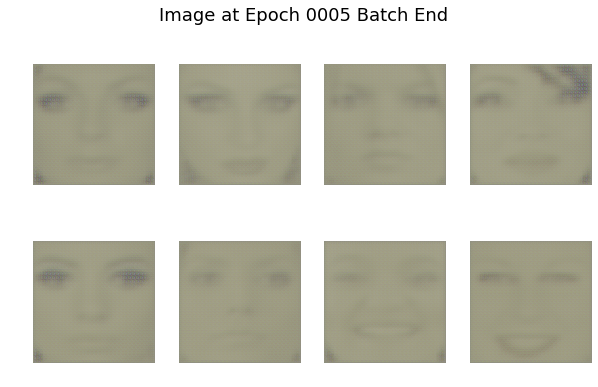

Epoch 6 starts !
Time for epoch 6 batch 5 is 1.322 sec
Time for epoch 6 batch 10 is 1.713 sec
Time for epoch 6 batch 15 is 2.094 sec
Time for epoch 6 batch 20 is 2.448 sec
Time for epoch 6 batch 25 is 2.789 sec
Time for epoch 6 batch 30 is 3.133 sec
Time for epoch 6 batch 35 is 3.474 sec
Time for epoch 6 is 4.710493 sec
Train L1 loss: 0.230
Test L1 loss: 0.203
Epoch 7 starts !
Time for epoch 7 batch 5 is 1.273 sec
Time for epoch 7 batch 10 is 1.617 sec
Time for epoch 7 batch 15 is 1.958 sec
Time for epoch 7 batch 20 is 2.319 sec
Time for epoch 7 batch 25 is 2.661 sec
Time for epoch 7 batch 30 is 3.010 sec
Time for epoch 7 batch 35 is 3.355 sec
Time for epoch 7 is 3.813506 sec
Train L1 loss: 0.253
Test L1 loss: 0.216
Epoch 8 starts !
Time for epoch 8 batch 5 is 1.260 sec
Time for epoch 8 batch 10 is 1.602 sec
Time for epoch 8 batch 15 is 1.944 sec
Time for epoch 8 batch 20 is 2.285 sec
Time for epoch 8 batch 25 is 2.641 sec
Time for epoch 8 batch 30 is 2.985 sec
Time for epoch 8 batch 3

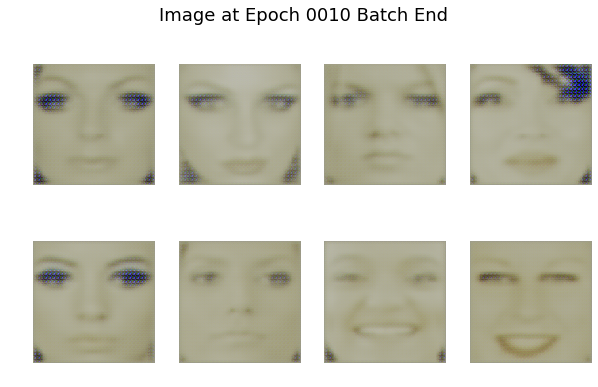

Epoch 11 starts !
Time for epoch 11 batch 5 is 1.277 sec
Time for epoch 11 batch 10 is 1.626 sec
Time for epoch 11 batch 15 is 1.969 sec
Time for epoch 11 batch 20 is 2.322 sec
Time for epoch 11 batch 25 is 2.668 sec
Time for epoch 11 batch 30 is 3.025 sec
Time for epoch 11 batch 35 is 3.376 sec
Time for epoch 11 is 3.836324 sec
Train L1 loss: 0.316
Test L1 loss: 0.238
Epoch 12 starts !
Time for epoch 12 batch 5 is 1.290 sec
Time for epoch 12 batch 10 is 1.635 sec
Time for epoch 12 batch 15 is 1.991 sec
Time for epoch 12 batch 20 is 2.338 sec
Time for epoch 12 batch 25 is 2.682 sec
Time for epoch 12 batch 30 is 3.035 sec
Time for epoch 12 batch 35 is 3.392 sec
Time for epoch 12 is 4.710073 sec
Train L1 loss: 0.324
Test L1 loss: 0.238
Epoch 13 starts !
Time for epoch 13 batch 5 is 1.285 sec
Time for epoch 13 batch 10 is 1.639 sec
Time for epoch 13 batch 15 is 1.998 sec
Time for epoch 13 batch 20 is 2.357 sec
Time for epoch 13 batch 25 is 2.717 sec
Time for epoch 13 batch 30 is 3.062 sec

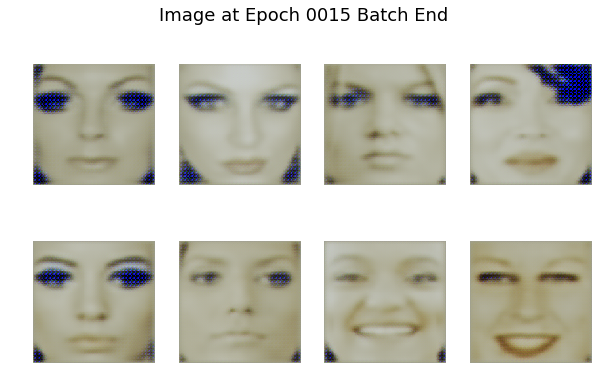

Epoch 16 starts !
Time for epoch 16 batch 5 is 1.267 sec
Time for epoch 16 batch 10 is 1.681 sec
Time for epoch 16 batch 15 is 2.040 sec
Time for epoch 16 batch 20 is 2.419 sec
Time for epoch 16 batch 25 is 2.783 sec
Time for epoch 16 batch 30 is 3.147 sec
Time for epoch 16 batch 35 is 3.537 sec
Time for epoch 16 is 4.989332 sec
Train L1 loss: 0.350
Test L1 loss: 0.233
Epoch 17 starts !
Time for epoch 17 batch 5 is 1.338 sec
Time for epoch 17 batch 10 is 1.729 sec
Time for epoch 17 batch 15 is 2.103 sec
Time for epoch 17 batch 20 is 2.462 sec
Time for epoch 17 batch 25 is 2.809 sec
Time for epoch 17 batch 30 is 3.168 sec
Time for epoch 17 batch 35 is 3.513 sec
Time for epoch 17 is 3.962988 sec
Train L1 loss: 0.349
Test L1 loss: 0.228
Epoch 18 starts !
Time for epoch 18 batch 5 is 1.280 sec
Time for epoch 18 batch 10 is 1.664 sec
Time for epoch 18 batch 15 is 2.009 sec
Time for epoch 18 batch 20 is 2.393 sec
Time for epoch 18 batch 25 is 2.739 sec
Time for epoch 18 batch 30 is 3.086 sec

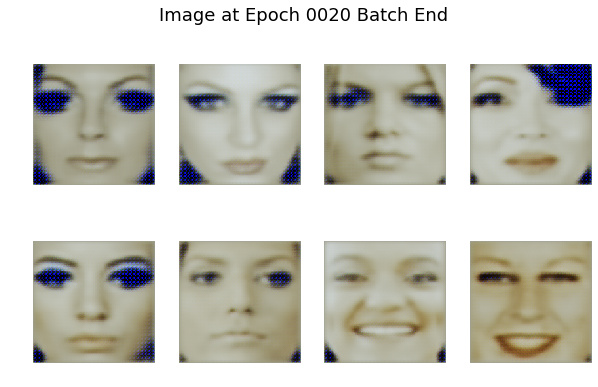

Epoch 21 starts !
Time for epoch 21 batch 5 is 1.233 sec
Time for epoch 21 batch 10 is 1.579 sec
Time for epoch 21 batch 15 is 1.926 sec
Time for epoch 21 batch 20 is 2.271 sec
Time for epoch 21 batch 25 is 2.615 sec
Time for epoch 21 batch 30 is 2.971 sec
Time for epoch 21 batch 35 is 3.318 sec
Time for epoch 21 is 3.761662 sec
Train L1 loss: 0.370
Test L1 loss: 0.231
Epoch 22 starts !
Time for epoch 22 batch 5 is 1.228 sec
Time for epoch 22 batch 10 is 1.573 sec
Time for epoch 22 batch 15 is 1.918 sec
Time for epoch 22 batch 20 is 2.263 sec
Time for epoch 22 batch 25 is 2.607 sec
Time for epoch 22 batch 30 is 2.952 sec
Time for epoch 22 batch 35 is 3.297 sec
Time for epoch 22 is 4.829245 sec
Train L1 loss: 0.372
Test L1 loss: 0.231
Epoch 23 starts !
Time for epoch 23 batch 5 is 1.241 sec
Time for epoch 23 batch 10 is 1.592 sec
Time for epoch 23 batch 15 is 1.939 sec
Time for epoch 23 batch 20 is 2.284 sec
Time for epoch 23 batch 25 is 2.630 sec
Time for epoch 23 batch 30 is 2.975 sec

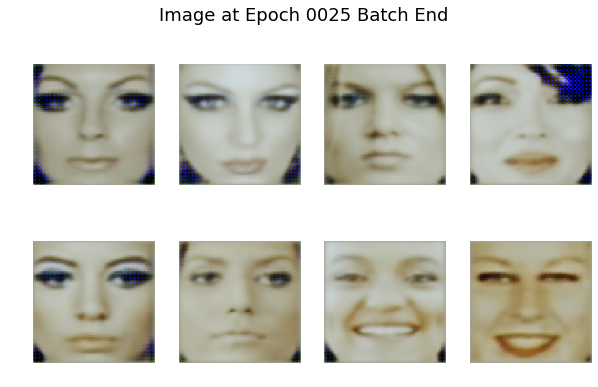

Epoch 26 starts !
Time for epoch 26 batch 5 is 1.304 sec
Time for epoch 26 batch 10 is 1.707 sec
Time for epoch 26 batch 15 is 2.084 sec
Time for epoch 26 batch 20 is 2.498 sec
Time for epoch 26 batch 25 is 2.868 sec
Time for epoch 26 batch 30 is 3.278 sec
Time for epoch 26 batch 35 is 3.643 sec
Time for epoch 26 is 5.454770 sec
Train L1 loss: 0.381
Test L1 loss: 0.232
Epoch 27 starts !
Time for epoch 27 batch 5 is 1.247 sec
Time for epoch 27 batch 10 is 1.592 sec
Time for epoch 27 batch 15 is 1.936 sec
Time for epoch 27 batch 20 is 2.281 sec
Time for epoch 27 batch 25 is 2.628 sec
Time for epoch 27 batch 30 is 2.974 sec
Time for epoch 27 batch 35 is 3.320 sec
Time for epoch 27 is 3.762833 sec
Train L1 loss: 0.381
Test L1 loss: 0.231
Epoch 28 starts !
Time for epoch 28 batch 5 is 1.243 sec
Time for epoch 28 batch 10 is 1.588 sec
Time for epoch 28 batch 15 is 1.937 sec
Time for epoch 28 batch 20 is 2.282 sec
Time for epoch 28 batch 25 is 2.627 sec
Time for epoch 28 batch 30 is 2.973 sec

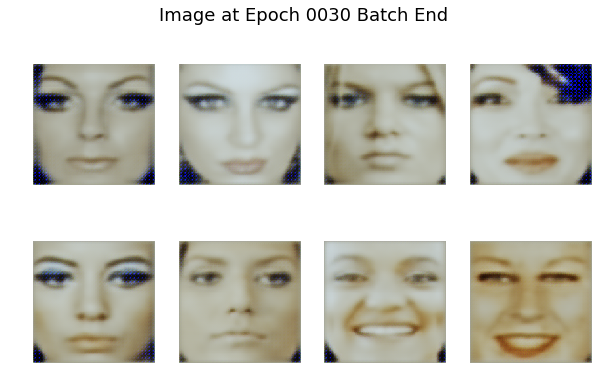

Epoch 31 starts !
Time for epoch 31 batch 5 is 1.238 sec
Time for epoch 31 batch 10 is 1.580 sec
Time for epoch 31 batch 15 is 1.938 sec
Time for epoch 31 batch 20 is 2.284 sec
Time for epoch 31 batch 25 is 2.628 sec
Time for epoch 31 batch 30 is 2.975 sec
Time for epoch 31 batch 35 is 3.322 sec
Time for epoch 31 is 3.763445 sec
Train L1 loss: 0.388
Test L1 loss: 0.233
Epoch 32 starts !
Time for epoch 32 batch 5 is 1.242 sec
Time for epoch 32 batch 10 is 1.589 sec
Time for epoch 32 batch 15 is 1.935 sec
Time for epoch 32 batch 20 is 2.285 sec
Time for epoch 32 batch 25 is 2.629 sec
Time for epoch 32 batch 30 is 2.974 sec
Time for epoch 32 batch 35 is 3.319 sec
Time for epoch 32 is 5.696652 sec
Train L1 loss: 0.392
Test L1 loss: 0.237
Epoch 33 starts !
Time for epoch 33 batch 5 is 1.250 sec
Time for epoch 33 batch 10 is 1.601 sec
Time for epoch 33 batch 15 is 1.997 sec
Time for epoch 33 batch 20 is 2.355 sec
Time for epoch 33 batch 25 is 2.732 sec
Time for epoch 33 batch 30 is 3.108 sec

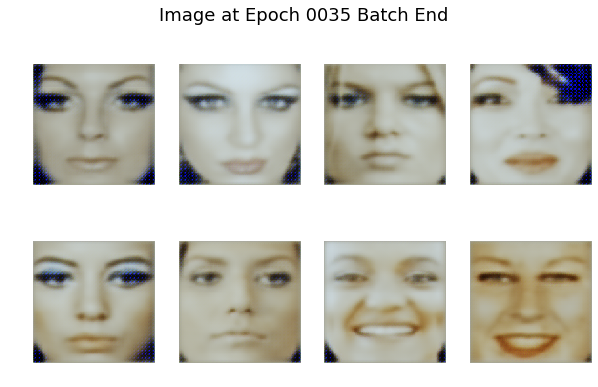

Epoch 36 starts !
Time for epoch 36 batch 5 is 1.233 sec
Time for epoch 36 batch 10 is 1.577 sec
Time for epoch 36 batch 15 is 1.936 sec
Time for epoch 36 batch 20 is 2.281 sec
Time for epoch 36 batch 25 is 2.630 sec
Time for epoch 36 batch 30 is 3.005 sec
Time for epoch 36 batch 35 is 3.377 sec
Time for epoch 36 is 6.588175 sec
Train L1 loss: 0.395
Test L1 loss: 0.235
Epoch 37 starts !
Time for epoch 37 batch 5 is 1.278 sec
Time for epoch 37 batch 10 is 1.624 sec
Time for epoch 37 batch 15 is 2.013 sec
Time for epoch 37 batch 20 is 2.391 sec
Time for epoch 37 batch 25 is 2.775 sec
Time for epoch 37 batch 30 is 3.125 sec
Time for epoch 37 batch 35 is 3.501 sec
Time for epoch 37 is 3.964621 sec
Train L1 loss: 0.401
Test L1 loss: 0.239
Epoch 38 starts !
Time for epoch 38 batch 5 is 1.263 sec
Time for epoch 38 batch 10 is 1.625 sec
Time for epoch 38 batch 15 is 2.003 sec
Time for epoch 38 batch 20 is 2.350 sec
Time for epoch 38 batch 25 is 2.736 sec
Time for epoch 38 batch 30 is 3.110 sec

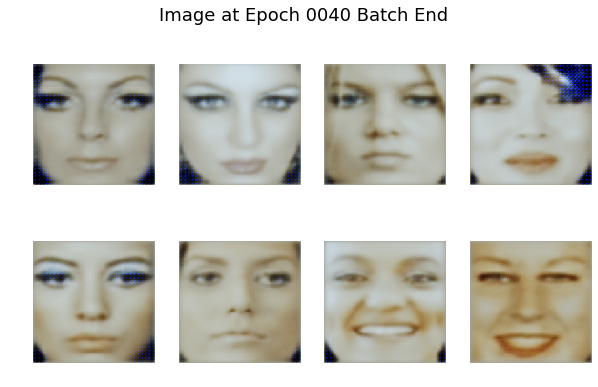

Epoch 41 starts !
Time for epoch 41 batch 5 is 1.224 sec
Time for epoch 41 batch 10 is 1.569 sec
Time for epoch 41 batch 15 is 1.914 sec
Time for epoch 41 batch 20 is 2.273 sec
Time for epoch 41 batch 25 is 2.638 sec
Time for epoch 41 batch 30 is 2.983 sec
Time for epoch 41 batch 35 is 3.329 sec
Time for epoch 41 is 3.773087 sec
Train L1 loss: 0.402
Test L1 loss: 0.234
Epoch 42 starts !
Time for epoch 42 batch 5 is 1.253 sec
Time for epoch 42 batch 10 is 1.599 sec
Time for epoch 42 batch 15 is 1.944 sec
Time for epoch 42 batch 20 is 2.298 sec
Time for epoch 42 batch 25 is 2.660 sec
Time for epoch 42 batch 30 is 3.007 sec
Time for epoch 42 batch 35 is 3.354 sec
Time for epoch 42 is 4.716064 sec
Train L1 loss: 0.404
Test L1 loss: 0.241
Epoch 43 starts !
Time for epoch 43 batch 5 is 1.284 sec
Time for epoch 43 batch 10 is 1.653 sec
Time for epoch 43 batch 15 is 2.009 sec
Time for epoch 43 batch 20 is 2.411 sec
Time for epoch 43 batch 25 is 2.758 sec
Time for epoch 43 batch 30 is 3.105 sec

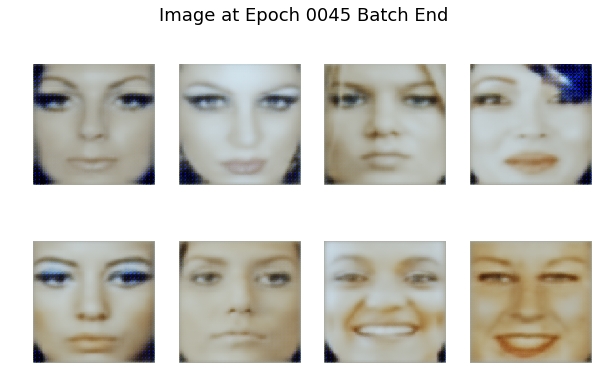

Epoch 46 starts !
Time for epoch 46 batch 5 is 1.305 sec
Time for epoch 46 batch 10 is 1.696 sec
Time for epoch 46 batch 15 is 2.074 sec
Time for epoch 46 batch 20 is 2.422 sec
Time for epoch 46 batch 25 is 2.803 sec
Time for epoch 46 batch 30 is 3.152 sec
Time for epoch 46 batch 35 is 3.501 sec
Time for epoch 46 is 4.973712 sec
Train L1 loss: 0.415
Test L1 loss: 0.237
Epoch 47 starts !
Time for epoch 47 batch 5 is 1.265 sec
Time for epoch 47 batch 10 is 1.631 sec
Time for epoch 47 batch 15 is 1.976 sec
Time for epoch 47 batch 20 is 2.321 sec
Time for epoch 47 batch 25 is 2.667 sec
Time for epoch 47 batch 30 is 3.050 sec
Time for epoch 47 batch 35 is 3.405 sec
Time for epoch 47 is 3.844676 sec
Train L1 loss: 0.413
Test L1 loss: 0.242
Epoch 48 starts !
Time for epoch 48 batch 5 is 1.308 sec
Time for epoch 48 batch 10 is 1.695 sec
Time for epoch 48 batch 15 is 2.058 sec
Time for epoch 48 batch 20 is 2.403 sec
Time for epoch 48 batch 25 is 2.750 sec
Time for epoch 48 batch 30 is 3.100 sec

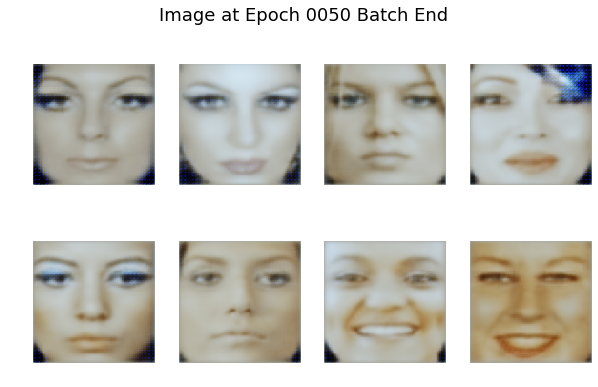

Epoch 51 starts !
Time for epoch 51 batch 5 is 1.320 sec
Time for epoch 51 batch 10 is 1.706 sec
Time for epoch 51 batch 15 is 2.055 sec
Time for epoch 51 batch 20 is 2.399 sec
Time for epoch 51 batch 25 is 2.746 sec
Time for epoch 51 batch 30 is 3.127 sec
Time for epoch 51 batch 35 is 3.488 sec
Time for epoch 51 is 3.934806 sec
Train L1 loss: 0.421
Test L1 loss: 0.243
Epoch 52 starts !
Time for epoch 52 batch 5 is 1.309 sec
Time for epoch 52 batch 10 is 1.660 sec
Time for epoch 52 batch 15 is 2.011 sec
Time for epoch 52 batch 20 is 2.357 sec
Time for epoch 52 batch 25 is 2.701 sec
Time for epoch 52 batch 30 is 3.048 sec
Time for epoch 52 batch 35 is 3.397 sec
Time for epoch 52 is 5.091034 sec
Train L1 loss: 0.422
Test L1 loss: 0.241
Epoch 53 starts !
Time for epoch 53 batch 5 is 1.238 sec
Time for epoch 53 batch 10 is 1.623 sec
Time for epoch 53 batch 15 is 2.013 sec
Time for epoch 53 batch 20 is 2.382 sec
Time for epoch 53 batch 25 is 2.755 sec
Time for epoch 53 batch 30 is 3.115 sec

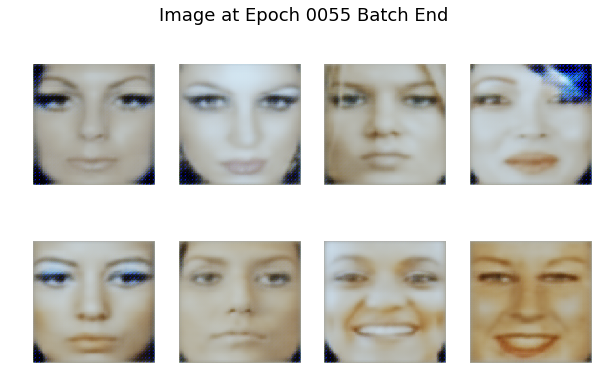

Epoch 56 starts !
Time for epoch 56 batch 5 is 1.277 sec
Time for epoch 56 batch 10 is 1.622 sec
Time for epoch 56 batch 15 is 1.970 sec
Time for epoch 56 batch 20 is 2.344 sec
Time for epoch 56 batch 25 is 2.690 sec
Time for epoch 56 batch 30 is 3.038 sec
Time for epoch 56 batch 35 is 3.416 sec
Time for epoch 56 is 5.530686 sec
Train L1 loss: 0.431
Test L1 loss: 0.237
Epoch 57 starts !
Time for epoch 57 batch 5 is 1.231 sec
Time for epoch 57 batch 10 is 1.579 sec
Time for epoch 57 batch 15 is 1.955 sec
Time for epoch 57 batch 20 is 2.328 sec
Time for epoch 57 batch 25 is 2.705 sec
Time for epoch 57 batch 30 is 3.051 sec
Time for epoch 57 batch 35 is 3.445 sec
Time for epoch 57 is 3.891997 sec
Train L1 loss: 0.434
Test L1 loss: 0.245
Epoch 58 starts !
Time for epoch 58 batch 5 is 1.305 sec
Time for epoch 58 batch 10 is 1.680 sec
Time for epoch 58 batch 15 is 2.059 sec
Time for epoch 58 batch 20 is 2.437 sec
Time for epoch 58 batch 25 is 2.815 sec
Time for epoch 58 batch 30 is 3.191 sec

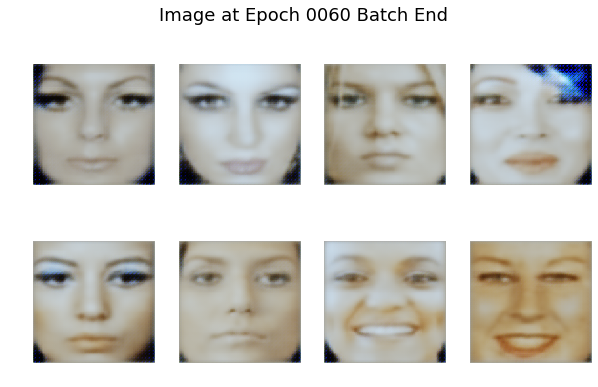

Epoch 61 starts !
Time for epoch 61 batch 5 is 1.262 sec
Time for epoch 61 batch 10 is 1.636 sec
Time for epoch 61 batch 15 is 1.999 sec
Time for epoch 61 batch 20 is 2.365 sec
Time for epoch 61 batch 25 is 2.725 sec
Time for epoch 61 batch 30 is 3.102 sec
Time for epoch 61 batch 35 is 3.476 sec
Time for epoch 61 is 3.937793 sec
Train L1 loss: 0.438
Test L1 loss: 0.243
Epoch 62 starts !
Time for epoch 62 batch 5 is 1.253 sec
Time for epoch 62 batch 10 is 1.598 sec
Time for epoch 62 batch 15 is 1.943 sec
Time for epoch 62 batch 20 is 2.288 sec
Time for epoch 62 batch 25 is 2.634 sec
Time for epoch 62 batch 30 is 2.996 sec
Time for epoch 62 batch 35 is 3.343 sec
Time for epoch 62 is 4.505303 sec
Train L1 loss: 0.453
Test L1 loss: 0.239
Epoch 63 starts !
Time for epoch 63 batch 5 is 1.289 sec
Time for epoch 63 batch 10 is 1.665 sec
Time for epoch 63 batch 15 is 2.014 sec
Time for epoch 63 batch 20 is 2.372 sec
Time for epoch 63 batch 25 is 2.739 sec
Time for epoch 63 batch 30 is 3.101 sec

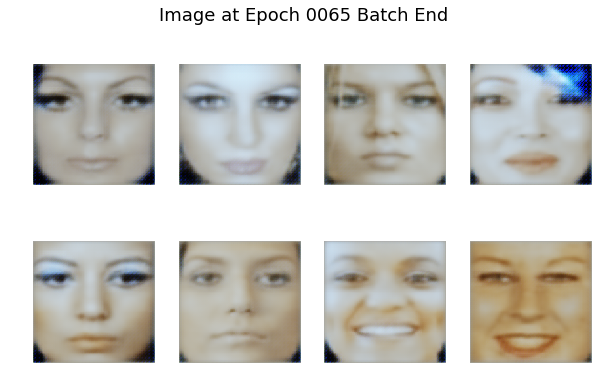

Epoch 66 starts !
Time for epoch 66 batch 5 is 1.274 sec
Time for epoch 66 batch 10 is 1.656 sec
Time for epoch 66 batch 15 is 2.003 sec
Time for epoch 66 batch 20 is 2.350 sec
Time for epoch 66 batch 25 is 2.741 sec
Time for epoch 66 batch 30 is 3.123 sec
Time for epoch 66 batch 35 is 3.509 sec
Time for epoch 66 is 4.711855 sec
Train L1 loss: 0.444
Test L1 loss: 0.249
Epoch 67 starts !
Time for epoch 67 batch 5 is 1.274 sec
Time for epoch 67 batch 10 is 1.656 sec
Time for epoch 67 batch 15 is 2.038 sec
Time for epoch 67 batch 20 is 2.384 sec
Time for epoch 67 batch 25 is 2.766 sec
Time for epoch 67 batch 30 is 3.142 sec
Time for epoch 67 batch 35 is 3.488 sec
Time for epoch 67 is 3.951766 sec
Train L1 loss: 0.463
Test L1 loss: 0.244
Epoch 68 starts !
Time for epoch 68 batch 5 is 1.254 sec
Time for epoch 68 batch 10 is 1.612 sec
Time for epoch 68 batch 15 is 1.986 sec
Time for epoch 68 batch 20 is 2.351 sec
Time for epoch 68 batch 25 is 2.723 sec
Time for epoch 68 batch 30 is 3.096 sec

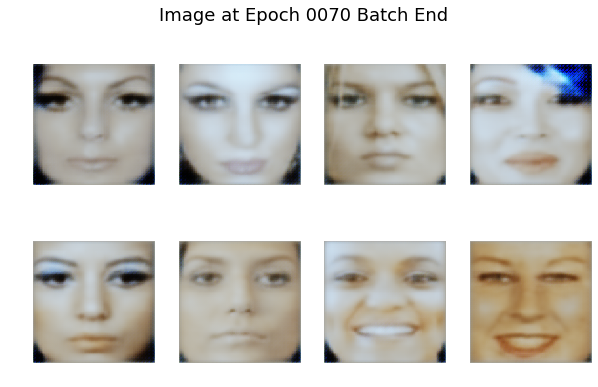

Epoch 71 starts !
Time for epoch 71 batch 5 is 1.297 sec
Time for epoch 71 batch 10 is 1.681 sec
Time for epoch 71 batch 15 is 2.093 sec
Time for epoch 71 batch 20 is 2.442 sec
Time for epoch 71 batch 25 is 2.832 sec
Time for epoch 71 batch 30 is 3.221 sec
Time for epoch 71 batch 35 is 3.590 sec
Time for epoch 71 is 4.050012 sec
Train L1 loss: 0.477
Test L1 loss: 0.240
Epoch 72 starts !
Time for epoch 72 batch 5 is 1.236 sec
Time for epoch 72 batch 10 is 1.583 sec
Time for epoch 72 batch 15 is 1.929 sec
Time for epoch 72 batch 20 is 2.276 sec
Time for epoch 72 batch 25 is 2.634 sec
Time for epoch 72 batch 30 is 2.983 sec
Time for epoch 72 batch 35 is 3.330 sec
Time for epoch 72 is 4.628880 sec
Train L1 loss: 0.464
Test L1 loss: 0.245
Epoch 73 starts !
Time for epoch 73 batch 5 is 1.249 sec
Time for epoch 73 batch 10 is 1.596 sec
Time for epoch 73 batch 15 is 1.941 sec
Time for epoch 73 batch 20 is 2.290 sec
Time for epoch 73 batch 25 is 2.635 sec
Time for epoch 73 batch 30 is 2.981 sec

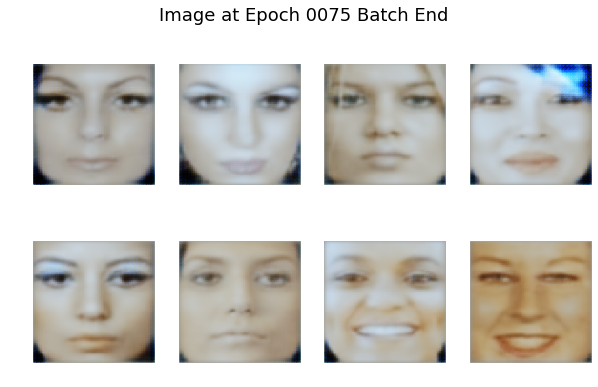

Epoch 76 starts !


In [ ]:
train(train_data, test_data_sample_y, data_y, data_n, test_data_y, test_data_n, EPOCHS)

In [3]:
generator = tf.keras.models.load_model('my_gen.h5')

W0419 22:12:11.057526 10540 hdf5_format.py:224] No training configuration found in save file: the model was *not* compiled. Compile it manually.


In [4]:
def load_image( infilename ) :
    img = Image.open( infilename )
    img.load()
    data = np.asarray( img, dtype="float32" )
    return data

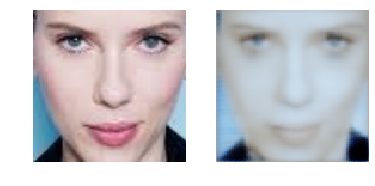

In [28]:
im = load_image("./Test/6-1.jpg")
im = np.array([cv2.resize(im, dsize=(128, 128))])
im = np.float32((im/127.5)-1)
fig, axs = plt.subplots(1,2)
axs[0].imshow(np.int32((im[0]+1)*127.5))
axs[0].axis('off')
new_image = generator(im, training=False)
axs[1].imshow(np.array((new_image[0]*127.5)+127.5).astype(int))
axs[1].axis('off')
plt.show()

(1, 128, 128, 3)


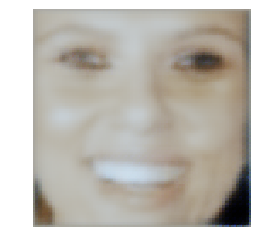

(1, 128, 128, 3)


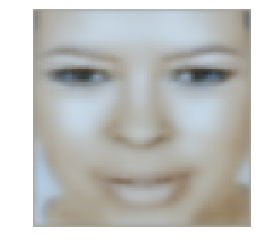

In [12]:
# im = np.expand_dims(im, axis=0)
print(im.shape)
new_image = generator(data_y[10:11,:,:,:], training=False)
plt.imshow(np.array((new_image[0]*127.5)+127.5).astype(int))
plt.axis('off')
plt.show()

-0.99215686


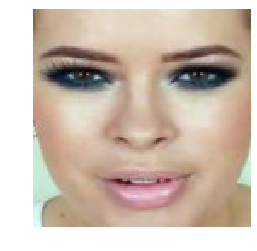

In [13]:
print(data_y[10].min())
plt.imshow(((data_y[10]*127.5)+127.5).astype(int))
plt.axis("off")
plt.show()

In [38]:
t1 = tf.constant([1,2,3])
t2 = tf.convert_to_tensor(np.array([1,2,3]), dtype=tf.int32)
tf.reduce_mean(tf.concat([t1, t2], -1)).numpy()

2

In [39]:
generator.save('my_gen.h5')
discriminator.save('my_dis.h5')

In [0]:
# Display a single image using the epoch number
def display_image(epoch_no):
    return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

In [0]:
anim_file = 'gan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('image*.png')
    filenames = sorted(filenames)
    filenames = [i for i in filenames if i not in image_file]
    last = -1
    for i,filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

import IPython
if IPython.version_info > (6,2,0,''):
    display.Image(filename=anim_file)

In [0]:
anim_file = 'gan_all.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('image*.png')
    filenames = sorted(filenames)
    for i,filename in enumerate(filenames):
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

In [0]:
anim_file = 'gan_epoch.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('image*.png')
    filenames = sorted(filenames)
    filenames = [i for i in filenames if i not in image_file and i.split("_")[-1]=="end.png" and i.split("_")[-2]=="batch"]
    for i,filename in enumerate(filenames):
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

In [0]:
with zipfile.ZipFile('GAN_Image.zip', 'w') as z:
    for image in filenames:
        z.write(image)

In [269]:
test_data_sample_n.min()

-1.0

In [288]:
value =tf.image.ssim(final_pred, tf.cast(test_data_sample_n, tf.float32), 2.0)
print(value)

tf.Tensor(
[0.5585507  0.6136067  0.6670673  0.653909   0.6127401  0.6011997
 0.529983   0.55564594], shape=(8,), dtype=float32)


In [287]:
tf.reduce_mean(tf.abs(final_pred - tf.cast(test_data_sample_n, tf.float32)))

<tf.Tensor: id=213957, shape=(), dtype=float32, numpy=0.14066555>

In [286]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
gan_loss = cross_entropy(tf.ones_like(final_pred),final_pred)
print(gan_loss)

tf.Tensor(0.56303835, shape=(), dtype=float32)


In [264]:
np.array((pred[0]*127.5)+127.5).astype(int).max()

231

In [0]:
plt.imshow(np.array((pred[3]*127.5)+127.5).astype(int))
plt.show()

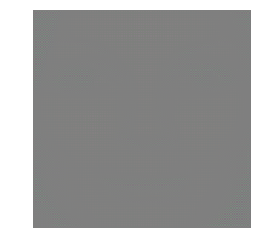

In [0]:
gg = generator(data_n[1:2], training=False)
hehe = discriminator(inputs=[gg, data_y[1:2]], training=False)
plt.imshow(tf.cast(((gg[0]+1.)*127.5),  dtype=tf.int32))
plt.axis('off')
plt.show()

In [0]:
def make_generator_model():
    initializer = tf.keras.initializers.RandomNormal(0., 0.02)
    main_input = layers.Input(shape=(256, 256, 3))
    model.add(layers.Conv2D(input_shape=(256, 256, 3),
                            filters=64, kernel_size=4,
                            padding='same',
                            kernel_initializer = initializer,
                            use_bias=False))
    model.add(layers.Conv2D(filters=128, kernel_size=4,
                            padding='same',
                            kernel_initializer = initializer,
                            use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(filters=256, kernel_size=4,
                            padding='same',
                            kernel_initializer = initializer,
                            use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(filters=512, kernel_size=4,
                            padding='same',
                            kernel_initializer = initializer,
                            use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(filters=512, kernel_size=4,
                            padding='same',
                            kernel_initializer = initializer,
                            use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(filters=512, kernel_size=4,
                            padding='same',
                            kernel_initializer = initializer,
                            use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(filters=512, kernel_size=4,
                            padding='same',
                            kernel_initializer = initializer,
                            use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(filters=512, kernel_size=4,
                            padding='same',
                            kernel_initializer = initializer,
                            use_bias=False))
    model.add(layers.BatchNormalization())
    model = tf.keras.Model(inputs=)
    
    

#Old Version

In [0]:
def downsample(x, filters, size, apply_batchnorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    x = layers.Conv2D(filters,
                      kernel_size=(size, size),
                      strides=2,
                      padding='same',
                      kernel_initializer=initializer,
                      use_bias=False)(x)
    if apply_batchnorm:
        x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)
    return x

def upsample(x1, x2, filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    x1 = layers.Conv2DTranspose(filters,
                              kernel_size=(size, size),
                              strides=2,
                              padding='same',
                              kernel_initializer=initializer,
                              use_bias=False)(x1)
    x1 = layers.BatchNormalization()(x1)
    if apply_dropout:
        x1 = layers.Dropout(0.5)(x1)
    x1 = layers.ReLU()(x1)
    x = layers.concatenate([x1, x2])
    return x

def upsample_single(x, filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    x = layers.Conv2DTranspose(filters,
                              kernel_size=(size, size),
                              strides=2,
                              padding='same',
                              kernel_initializer=initializer,
                              use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    if apply_dropout:
        x = layers.Dropout(0.5)(x)
    x = layers.LeakyReLU()(x)
    return x

In [0]:
def make_generator_model():
    initializer = tf.random_normal_initializer(0., 0.02)
    g_input = layers.Input(shape=(128, 128, 3))
    down1 = downsample(g_input, 64, 4, apply_batchnorm=False)
    down2 = downsample(down1, 128, 4)
    down3 = downsample(down2, 256, 4)
    down4 = downsample(down3, 256, 4)
    down5 = downsample(down4, 256, 4)
    down6 = downsample(down5, 256, 4)
    down7 = downsample(down6, 256, 4)

    up1 = upsample(down7, down6, 256, 4, apply_dropout=True)
    up2 = upsample(up1, down5, 256, 4, apply_dropout=True)
    up3 = upsample(up2, down4, 256, 4, apply_dropout=True)
    up4 = upsample(up3, down3, 128, 4)
    up5 = upsample(up4, down2, 64, 4)
    up6 = upsample(up5, down1, 32, 4)

    last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 
                                                (4, 4), 
                                                strides=2, 
                                                padding='same',
                                                kernel_initializer=initializer)(up6)
    out = layers.Activation('tanh')(last)
    model = tf.keras.Model(inputs=g_input, outputs=out)
    return model

In [0]:
def make_discriminator_model():
    initializer = tf.random_normal_initializer(0., 0.02)
    d_input = layers.Input(shape=(128, 128, 3))
    d_target = layers.Input(shape=(128, 128, 3))
    x = layers.concatenate([d_input, d_target])
    x = downsample(x, 64, 4, apply_batchnorm=False)
    x = downsample(x, 128, 4)
    x = layers.ZeroPadding2D()(x)
    x = layers.Conv2D(256,
                      (4, 4), 
                      strides=1, 
                      kernel_initializer=initializer, 
                      use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ZeroPadding2D()(x)
    out = layers.Conv2D(1,
                      (4, 4),
                      strides=1,
                      kernel_initializer=initializer)(x)
    model = tf.keras.Model(inputs=[d_input, d_target], outputs=out)
    return model

#试一试

In [0]:
OUTPUT_CHANNELS = 3

In [0]:
class Downsample(tf.keras.Model):
    
    def __init__(self, filters, size, apply_batchnorm=True):
        super(Downsample, self).__init__()
        self.apply_batchnorm = apply_batchnorm
        initializer = tf.random_normal_initializer(0., 0.02)

        self.conv1 = tf.keras.layers.Conv2D(filters, 
                                            (size, size), 
                                            strides=2, 
                                            padding='same',
                                            kernel_initializer=initializer,
                                            use_bias=False)
        if self.apply_batchnorm:
            self.batchnorm = tf.keras.layers.BatchNormalization()
            
    
    def call(self, x, training):
        x = self.conv1(x)
        if self.apply_batchnorm:
            x = self.batchnorm(x, training=training)
        x = tf.nn.leaky_relu(x)
        return x 


class Upsample(tf.keras.Model):
    
    def __init__(self, filters, size, apply_dropout=False):
        super(Upsample, self).__init__()
        self.apply_dropout = apply_dropout
        initializer = tf.random_normal_initializer(0., 0.02)

        self.up_conv = tf.keras.layers.Conv2DTranspose(filters, 
                                                       (size, size), 
                                                       strides=2, 
                                                       padding='same',
                                                       kernel_initializer=initializer,
                                                       use_bias=False)
        self.batchnorm = tf.keras.layers.BatchNormalization()
        if self.apply_dropout:
            self.dropout = tf.keras.layers.Dropout(0.5)

    def call(self, x1, x2, training):
        x = self.up_conv(x1)
        x = self.batchnorm(x, training=training)
        if self.apply_dropout:
            x = self.dropout(x, training=training)
        x = tf.nn.relu(x)
        x = tf.concat([x, x2], axis=-1)
        return x


class Generator(tf.keras.Model):
    
    def __init__(self):
        super(Generator, self).__init__()
        initializer = tf.random_normal_initializer(0., 0.02)
        

        self.down1 = Downsample(64, 4, apply_batchnorm=False)
        self.down2 = Downsample(128, 4)
        self.down3 = Downsample(256, 4)
        self.down4 = Downsample(512, 4)
        self.down5 = Downsample(512, 4)
        self.down6 = Downsample(512, 4)
        self.down7 = Downsample(512, 4)
        self.down8 = Downsample(512, 4)

        self.up1 = Upsample(512, 4, apply_dropout=True)
        self.up2 = Upsample(512, 4, apply_dropout=True)
        self.up3 = Upsample(512, 4, apply_dropout=True)
        self.up4 = Upsample(512, 4)
        self.up5 = Upsample(256, 4)
        self.up6 = Upsample(128, 4)
        self.up7 = Upsample(64, 4)

        self.last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 
                                                    (4, 4), 
                                                    strides=2, 
                                                    padding='same',
                                                    kernel_initializer=initializer)


    def call(self, x, training):
        # x shape == (bs, 256, 256, 3)    
        x1 = self.down1(x, training=training) # (bs, 128, 128, 64)
        x2 = self.down2(x1, training=training) # (bs, 64, 64, 128)
        x3 = self.down3(x2, training=training) # (bs, 32, 32, 256)
        x4 = self.down4(x3, training=training) # (bs, 16, 16, 512)
        x5 = self.down5(x4, training=training) # (bs, 8, 8, 512)
        x6 = self.down6(x5, training=training) # (bs, 4, 4, 512)
        x7 = self.down7(x6, training=training) # (bs, 2, 2, 512)
        x8 = self.down8(x7, training=training) # (bs, 1, 1, 512)

        x9 = self.up1(x8, x7, training=training) # (bs, 2, 2, 1024)
        x10 = self.up2(x9, x6, training=training) # (bs, 4, 4, 1024)
        x11 = self.up3(x10, x5, training=training) # (bs, 8, 8, 1024)
        x12 = self.up4(x11, x4, training=training) # (bs, 16, 16, 1024)
        x13 = self.up5(x12, x3, training=training) # (bs, 32, 32, 512)
        x14 = self.up6(x13, x2, training=training) # (bs, 64, 64, 256)
        x15 = self.up7(x14, x1, training=training) # (bs, 128, 128, 128)

        x16 = self.last(x15) # (bs, 256, 256, 3)
        x16 = tf.nn.tanh(x16)

        return x16

In [0]:
class DiscDownsample(tf.keras.Model):
    
    def __init__(self, filters, size, apply_batchnorm=True):
        super(DiscDownsample, self).__init__()
        self.apply_batchnorm = apply_batchnorm
        initializer = tf.random_normal_initializer(0., 0.02)

        self.conv1 = tf.keras.layers.Conv2D(filters, 
                                            (size, size), 
                                            strides=2, 
                                            padding='same',
                                            kernel_initializer=initializer,
                                            use_bias=False)
        if self.apply_batchnorm:
            self.batchnorm = tf.keras.layers.BatchNormalization()
            
    def call(self, x, training):
        x = self.conv1(x)
        if self.apply_batchnorm:
            x = self.batchnorm(x, training=training)
        x = tf.nn.leaky_relu(x)
        return x 

class Discriminator(tf.keras.Model):
    
    def __init__(self):
        super(Discriminator, self).__init__()
        initializer = tf.random_normal_initializer(0., 0.02)

        self.down1 = DiscDownsample(64, 4, False)
        self.down2 = DiscDownsample(128, 4)
        self.down3 = DiscDownsample(256, 4)

        # we are zero padding here with 1 because we need our shape to 
        # go from (batch_size, 32, 32, 256) to (batch_size, 31, 31, 512)
        self.zero_pad1 = tf.keras.layers.ZeroPadding2D()
        self.conv = tf.keras.layers.Conv2D(512, 
                                           (4, 4), 
                                           strides=1, 
                                           kernel_initializer=initializer, 
                                           use_bias=False)
        self.batchnorm1 = tf.keras.layers.BatchNormalization()

        # shape change from (batch_size, 31, 31, 512) to (batch_size, 30, 30, 1)
        self.zero_pad2 = tf.keras.layers.ZeroPadding2D()
        self.last = tf.keras.layers.Conv2D(1, 
                                           (4, 4), 
                                           strides=1,
                                           kernel_initializer=initializer)

#     @tf.contrib.eager.defun
    def call(self, inp, tar, training):
        # concatenating the input and the target
        x = tf.concat([inp, tar], axis=-1) # (bs, 256, 256, channels*2)
        x = self.down1(x, training=training) # (bs, 128, 128, 64)
        x = self.down2(x, training=training) # (bs, 64, 64, 128)
        x = self.down3(x, training=training) # (bs, 32, 32, 256)

        x = self.zero_pad1(x) # (bs, 34, 34, 256)
        x = self.conv(x)      # (bs, 31, 31, 512)
        x = self.batchnorm1(x, training=training)
        x = tf.nn.leaky_relu(x)

        x = self.zero_pad2(x) # (bs, 33, 33, 512)
        # don't add a sigmoid activation here since
        # the loss function expects raw logits.
        x = self.last(x)      # (bs, 30, 30, 1)

        return x

In [0]:
# The call function of Generator and Discriminator have been decorated
# with tf.contrib.eager.defun()
# We get a performance speedup if defun is used (~25 seconds per epoch)
generator = Generator()
discriminator = Discriminator()

In [0]:
LAMBDA = 100

In [0]:
def discriminator_loss(disc_real_output, disc_generated_output):
    real_loss = tf.losses.sigmoid_cross_entropy(multi_class_labels = tf.ones_like(disc_real_output), 
                                              logits = disc_real_output)
    generated_loss = tf.losses.sigmoid_cross_entropy(multi_class_labels = tf.zeros_like(disc_generated_output), 
                                                   logits = disc_generated_output)

    total_disc_loss = real_loss + generated_loss

    return total_disc_loss

In [0]:
def generator_loss(disc_generated_output, gen_output, target):
    gan_loss = tf.losses.sigmoid_cross_entropy(multi_class_labels = tf.ones_like(disc_generated_output),
                                             logits = disc_generated_output) 
    # mean absolute error
    l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

    total_gen_loss = gan_loss + (LAMBDA * l1_loss)

    return total_gen_loss

In [0]:
generator_optimizer = tf.train.AdamOptimizer(2e-4, beta1=0.5)
discriminator_optimizer = tf.train.AdamOptimizer(2e-4, beta1=0.5)

In [0]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [0]:
EPOCHS = 200

In [0]:
def generate_images(model, test_input, tar):
    # the training=True is intentional here since
    # we want the batch statistics while running the model
    # on the test dataset. If we use training=False, we will get 
    # the accumulated statistics learned from the training dataset
    # (which we don't want)
    prediction = model(test_input, training=True)
    plt.figure(figsize=(15,15))

    display_list = [test_input[0], tar[0], prediction[0]]
    title = ['Input Image', 'Ground Truth', 'Predicted Image']

    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i])
        # getting the pixel values between [0, 1] to plot it.
        plt.imshow(display_list[i] * 0.5 + 0.5)
        plt.axis('off')
        plt.show()

In [0]:
def train(dataset, epochs):  
    for epoch in range(epochs):
        start = time.time()

    for input_image, target in dataset:
        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            gen_output = generator(input_image, training=True)

            disc_real_output = discriminator(input_image, target, training=True)
            disc_generated_output = discriminator(input_image, gen_output, training=True)

            gen_loss = generator_loss(disc_generated_output, gen_output, target)
            disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

        generator_gradients = gen_tape.gradient(gen_loss, 
                                              generator.variables)
        discriminator_gradients = disc_tape.gradient(disc_loss, 
                                                   discriminator.variables)

        generator_optimizer.apply_gradients(zip(generator_gradients, 
                                              generator.variables))
        discriminator_optimizer.apply_gradients(zip(discriminator_gradients, 
                                                  discriminator.variables))

    if epoch % 1 == 0:
        clear_output(wait=True)
        for inp, tar in test_dataset.take(1):
            generate_images(generator, inp, tar)

    # saving (checkpoint) the model every 20 epochs
    if (epoch + 1) % 20 == 0:
        checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1,
                                                        time.time()-start))

In [0]:
def train(dataset, epochs):  
    for epoch in range(epochs):
        start = time.time()

    for input_image, target in dataset:
        
        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            with tf.Session(config=config) as sess:
                gen_output = sess.run(generator(input_image, training=True))
            gen_output = generator(input_image, training=True)

            disc_real_output = discriminator(input_image, target, training=True)
            disc_generated_output = discriminator(input_image, gen_output, training=True)

            gen_loss = generator_loss(disc_generated_output, gen_output, target)
            disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

        generator_gradients = gen_tape.gradient(gen_loss, 
                                              generator.variables)
        discriminator_gradients = disc_tape.gradient(disc_loss, 
                                                   discriminator.variables)

        generator_optimizer.apply_gradients(zip(generator_gradients, 
                                              generator.variables))
        discriminator_optimizer.apply_gradients(zip(discriminator_gradients, 
                                                  discriminator.variables))

    if epoch % 1 == 0:
        clear_output(wait=True)
        for inp, tar in test_dataset.take(1):
            generate_images(generator, inp, tar)

    # saving (checkpoint) the model every 20 epochs
    if (epoch + 1) % 20 == 0:
        checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1,
                                                        time.time()-start))

In [0]:
def train(data_n, data_y, epochs):
    input_image = tf.placeholder(tf.float32, shape=[None, 256, 256, 3])
    target = tf.placeholder(tf.float32, shape=[None, 256, 256, 3])
    for epoch in range(epochs):
        start = time.time()
        with tf.Session(config=config) as sess:
            generator = Generator()
            discriminator = Discriminator()
            sess.run(tf.global_variables_initializer())
            with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
                gen_output = sess.run(generator(input_image, training=True),
                                      feed_dict={input_image:data_y})
                

In [0]:
x = tf.placeholder(tf.float32, shape=[1,1])
def hehe(x):
    return x

In [0]:
with tf.Session() as sess:
    ss= sess.run(hehe(x), feed_dict={x:np.array([[1]])})
print(ss)

[[1.]]


In [0]:
train(data_n, data_y, 1)

In [0]:
train_dataset = zip(data_n, data_y)
train(train_dataset, 1)

#别的

In [0]:
    def generator(self, image, y=None):
        with tf.variable_scope("generator") as scope:

            s = self.output_size
            s2, s4, s8, s16, s32, s64, s128 = int(s/2), int(s/4), int(s/8), int(s/16), int(s/32), int(s/64), int(s/128)

            # image is (256 x 256 x input_c_dim)
            e1 = conv2d(image, self.gf_dim, name='g_e1_conv')
            # e1 is (128 x 128 x self.gf_dim)
            e2 = self.g_bn_e2(conv2d(lrelu(e1), self.gf_dim*2, name='g_e2_conv'))
            # e2 is (64 x 64 x self.gf_dim*2)
            e3 = self.g_bn_e3(conv2d(lrelu(e2), self.gf_dim*4, name='g_e3_conv'))
            # e3 is (32 x 32 x self.gf_dim*4)
            e4 = self.g_bn_e4(conv2d(lrelu(e3), self.gf_dim*8, name='g_e4_conv'))
            # e4 is (16 x 16 x self.gf_dim*8)
            e5 = self.g_bn_e5(conv2d(lrelu(e4), self.gf_dim*8, name='g_e5_conv'))
            # e5 is (8 x 8 x self.gf_dim*8)
            e6 = self.g_bn_e6(conv2d(lrelu(e5), self.gf_dim*8, name='g_e6_conv'))
            # e6 is (4 x 4 x self.gf_dim*8)
            e7 = self.g_bn_e7(conv2d(lrelu(e6), self.gf_dim*8, name='g_e7_conv'))
            # e7 is (2 x 2 x self.gf_dim*8)
            e8 = self.g_bn_e8(conv2d(lrelu(e7), self.gf_dim*8, name='g_e8_conv'))
            # e8 is (1 x 1 x self.gf_dim*8)

            self.d1, self.d1_w, self.d1_b = deconv2d(tf.nn.relu(e8),
                [self.batch_size, s128, s128, self.gf_dim*8], name='g_d1', with_w=True)
            d1 = tf.nn.dropout(self.g_bn_d1(self.d1), 0.5)
            d1 = tf.concat([d1, e7], 3)
            # d1 is (2 x 2 x self.gf_dim*8*2)

            self.d2, self.d2_w, self.d2_b = deconv2d(tf.nn.relu(d1),
                [self.batch_size, s64, s64, self.gf_dim*8], name='g_d2', with_w=True)
            d2 = tf.nn.dropout(self.g_bn_d2(self.d2), 0.5)
            d2 = tf.concat([d2, e6], 3)
            # d2 is (4 x 4 x self.gf_dim*8*2)

            self.d3, self.d3_w, self.d3_b = deconv2d(tf.nn.relu(d2),
                [self.batch_size, s32, s32, self.gf_dim*8], name='g_d3', with_w=True)
            d3 = tf.nn.dropout(self.g_bn_d3(self.d3), 0.5)
            d3 = tf.concat([d3, e5], 3)
            # d3 is (8 x 8 x self.gf_dim*8*2)

            self.d4, self.d4_w, self.d4_b = deconv2d(tf.nn.relu(d3),
                [self.batch_size, s16, s16, self.gf_dim*8], name='g_d4', with_w=True)
            d4 = self.g_bn_d4(self.d4)
            d4 = tf.concat([d4, e4], 3)
            # d4 is (16 x 16 x self.gf_dim*8*2)

            self.d5, self.d5_w, self.d5_b = deconv2d(tf.nn.relu(d4),
                [self.batch_size, s8, s8, self.gf_dim*4], name='g_d5', with_w=True)
            d5 = self.g_bn_d5(self.d5)
            d5 = tf.concat([d5, e3], 3)
            # d5 is (32 x 32 x self.gf_dim*4*2)

            self.d6, self.d6_w, self.d6_b = deconv2d(tf.nn.relu(d5),
                [self.batch_size, s4, s4, self.gf_dim*2], name='g_d6', with_w=True)
            d6 = self.g_bn_d6(self.d6)
            d6 = tf.concat([d6, e2], 3)
            # d6 is (64 x 64 x self.gf_dim*2*2)

            self.d7, self.d7_w, self.d7_b = deconv2d(tf.nn.relu(d6),
                [self.batch_size, s2, s2, self.gf_dim], name='g_d7', with_w=True)
            d7 = self.g_bn_d7(self.d7)
            d7 = tf.concat([d7, e1], 3)
            # d7 is (128 x 128 x self.gf_dim*1*2)

            self.d8, self.d8_w, self.d8_b = deconv2d(tf.nn.relu(d7),
                [self.batch_size, s, s, self.output_c_dim], name='g_d8', with_w=True)
            # d8 is (256 x 256 x output_c_dim)

            return tf.nn.tanh(self.d8)

In [0]:
class GAN(object):
    def __init__(self, g_size_list, d_size_list):
        self.z_fake = tf.placeholder(tf.float32, shape=[None, g_size_list[0]])
        self.x_real = tf.placeholder(tf.float32, shape=[None, g_size_list[0]])
        self.x_fake_test = tf.placeholder(tf.float32, shape=[None, g_size_list[0]])
        self.b_0 = tf.placeholder(tf.float32, shape=[None, g_size_list[0]])
        self.b_1 = tf.placeholder(tf.float32, shape=[None, g_size_list[0]])
        self.drop_out = tf.placeholder(dtype=tf.float32)
        with tf.variable_scope('generator', reuse=True):
            self.theta_G_0 = []
            self.theta_G_1 = []
            self.theta_G_2 = []
            self.theta_G_3 = []
            for i in range(len(g_size_list)-1):
                self.theta_G_0.append(tf.Variable(tf.random_normal([g_size_list[i],
                                                                  g_size_list[i+1]],
                                                                  mean=0.0,
                                                                  stddev=0.02)))
                self.theta_G_0.append(tf.Variable(tf.constant(0.,shape=[1, g_size_list[i+1]])))
                self.theta_G_1.append(tf.Variable(tf.random_normal([g_size_list[i],
                                                                  g_size_list[i+1]],
                                                                  mean=0.0,
                                                                  stddev=0.02)))
                self.theta_G_1.append(tf.Variable(tf.constant(0.,shape=[1, g_size_list[i+1]])))
                self.theta_G_2.append(tf.Variable(tf.random_normal([g_size_list[i],
                                                                  g_size_list[i+1]],
                                                                  mean=0.0,
                                                                  stddev=0.02)))
                self.theta_G_2.append(tf.Variable(tf.constant(0.,shape=[1, g_size_list[i+1]])))
                self.theta_G_3.append(tf.Variable(tf.random_normal([g_size_list[i],
                                                                  g_size_list[i+1]],
                                                                  mean=0.0,
                                                                  stddev=0.02)))
                self.theta_G_3.append(tf.Variable(tf.constant(0.,shape=[1, g_size_list[i+1]])))
            
        with tf.variable_scope('discriminator', reuse=True):
            self.theta_D = []
            for i in range(len(d_size_list)-1):
                self.theta_D.append(tf.Variable(tf.random_normal([d_size_list[i],
                                                                  d_size_list[i+1]],
                                                                  mean=0.0,
                                                                  stddev=0.02)))
                self.theta_D.append(tf.Variable(tf.constant(0.,shape=[1, d_size_list[i+1]])))
    
    def s_func(self, theta_G, g_in, actf):
        for i in range(0, len(theta_G)-2, 2):
            g_out = actf(tf.matmul(g_in, theta_G[i]) + theta_G[i+1])
            g_in = g_out
        g_out = tf.nn.tanh(tf.matmul(g_in, theta_G[-2]) + theta_G[-1])
        return g_out
    
    def t_func(self, theta_G, g_in, actf):
        for i in range(0, len(theta_G)-2, 2):
            g_out = actf(tf.matmul(g_in, theta_G[i]) + theta_G[i+1])
            g_in = g_out
        g_out = tf.nn.tanh(tf.matmul(g_in, theta_G[-2]) + theta_G[-1])
        return g_out
    
    def coupling_layer(self, c_in, b, theta_G_0, theta_G_1, actf):
        x_0 = tf.multiply(b, c_in)
        c_out = x_0 + tf.multiply((1-b),
                               (tf.multiply(c_in,
                                            tf.exp(self.s_func(theta_G_0,
                                                                    x_0,
                                                                    actf))))+\
                                       self.t_func(theta_G_1, x_0, actf))
        return c_out
    
    def inverse_coupling_layer(self, c_out, b, theta_G_0, theta_G_1, actf):
        y_0 = tf.multiply(b, c_out)
        c_in = y_0 + tf.multiply((1-b),
                                 tf.multiply((c_out-self.t_func(theta_G_1, 
                                                                         y_0,
                                                                         actf)),
                                                     tf.exp(-self.s_func(theta_G_0, 
                                                                    y_0,
                                                                    actf))))
        return c_in
    
    def generator(self, z, b_0, b_1, actf):
        c_0 = self.coupling_layer(z, b_0, self.theta_G_0, self.theta_G_1, actf)
        x = self.coupling_layer(c_0, b_1, self.theta_G_2, self.theta_G_3, actf)
        return c_0, x
    
    def inverse_generator(self, x, b_0, b_1, actf):
        c_0 = self.inverse_coupling_layer(x, b_1, self.theta_G_2,
                                          self.theta_G_3, actf)
        z = self.inverse_coupling_layer(c_0, b_0, self.theta_G_0,
                                          self.theta_G_1, actf)
        return c_0, z
    
    def get_q(self, z, c_0, x, b_0, b_1, actf):
        dist = tfp.distributions.Normal(loc=0., scale=1.)
        z  = z[:,43:53]
        log_p_z = tf.reduce_sum(tf.log(dist.prob(z)), axis=1, keepdims=True)
        c_0_0 = tf.math.multiply(b_0, c_0)
        c_1_0 = tf.math.multiply(b_1, x)
        log_g_prob = log_p_z + tf.reduce_sum(-self.s_func(self.theta_G_0,
                                                          c_0_0,
                                                          actf),
                                             axis=1,
                                             keepdims=True) +\
        tf.reduce_sum(-self.s_func(self.theta_G_2,
                                   c_1_0,
                                   actf),
                      axis=1,
                      keepdims=True)
        return log_g_prob
                                  
            
    def discriminator(self, d_in, actf, drop_out, log_q):
        for i in range(0, len(self.theta_D)-2, 2):
            d_out = actf(tf.matmul(d_in, self.theta_D[i])+self.theta_D[i+1])
            d_out = tf.nn.dropout(d_out, drop_out)
            d_in = d_out
        d_out = tf.nn.sigmoid(tf.matmul(d_in, self.theta_D[-2])+self.theta_D[-1]- log_q)
        return d_out
    
    def energy_function(self, d_in, actf, drop_out):
        for i in range(0, len(self.theta_D)-2, 2):
            d_out = actf(tf.matmul(d_in, self.theta_D[i])+self.theta_D[i+1])
            d_out = tf.nn.dropout(d_out, drop_out)
            d_in = d_out
        d_out = tf.exp(tf.matmul(d_in, self.theta_D[-2]))*tf.exp(self.theta_D[-1])
        return d_out
    
    def pre_run(self, g_actf=tf.nn.relu, d_actf=tf.nn.relu, lr = 0.0001):
        self.c_0_fake, self.x_fake = self.generator(self.z_fake, self.b_0, self.b_1, g_actf)
        self.c_0_real, self.z_real = self.inverse_generator(self.x_real, self.b_0, self.b_1, g_actf)
        self.c_0_fake_r, self.z_fake_r = self.inverse_generator(self.x_fake, self.b_0, self.b_1, g_actf)
        self.log_q_fake = self.get_q(self.z_fake, self.c_0_fake, self.x_fake, self.b_0, self.b_1, g_actf)
        self.log_q_real = self.get_q(self.z_real, self.c_0_real, self.x_real, self.b_0, self.b_1, g_actf)
        self.d_real = self.discriminator(self.x_real, d_actf, self.drop_out, self.log_q_real)
        self.d_fake = self.discriminator(self.x_fake, d_actf, self.drop_out, self.log_q_fake)
        self.eps = 1e-3
        self.d_loss = -tf.reduce_mean(tf.log(self.d_real+self.eps)) - tf.reduce_mean(tf.log(1-self.d_fake+self.eps))
#         self.g_loss = -tf.reduce_mean(tf.log(self.d_fake+self.eps)) + tf.reduce_mean(tf.log(1-self.d_fake+self.eps))
        self.g_loss = tf.reduce_mean(tf.log(1-self.d_fake+self.eps))
        self.T_vars = tf.trainable_variables()
        self.D_vars = [var for var in self.T_vars if var.name.startswith('discriminator')]
        self.G_vars = [var for var in self.T_vars if var.name.startswith('generator')]
        self.d_solver = tf.train.AdamOptimizer(lr).minimize(self.d_loss,
                                                          var_list=self.D_vars)
        self.g_solver = tf.train.AdamOptimizer(lr).minimize(self.g_loss,
                                                          var_list=self.G_vars)
        self.e_test = self.energy_function(self.x_fake_test, d_actf, self.drop_out)

#无用

In [0]:
file_name = "gan_makeup_data_96.zip"
zip_file = zipfile.ZipFile(filename)
if os.path.isdir(file_name + "_files"):
    pass
else:
    os.mkdir(file_name + "_files")
for names in zip_file.namelist():
    zip_file.extract(names, file_name + "_files/")
zip_file.close

<bound method ZipFile.close of <zipfile.ZipFile filename='gan_makeup_data_96.zip' mode='r'>>

In [0]:
yes_list = os.listdir("gan_makeup_data_96.zip_files/gan_makeup_data_96/with/")
no_list = os.listdir("gan_makeup_data_96.zip_files/gan_makeup_data_96/without/")
yes_list = [i for i in yes_list if len(i.split("_"))!=2]
no_list = [i for i in no_list if len(i.split("_"))!=2]
print(len(yes_list))
print(len(no_list))

469
520


(96, 96, 3)


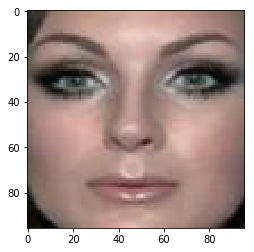

(96, 96, 3)


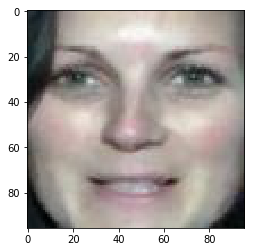

In [0]:
img = plt.imread("gan_makeup_data_96.zip_files/gan_makeup_data_96/with/001_1_y.jpg")
print(img.shape)
plt.imshow(img)
plt.show()
img = plt.imread("gan_makeup_data_96.zip_files/gan_makeup_data_96/without/001_1_n.jpg")
print(img.shape)
plt.imshow(img)
plt.show()